In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/assuncaolfi/Projects/blog/posts/fantasy-football':
  os.chdir(r'/Users/assuncaolfi/Projects/blog/posts/fantasy-football')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/6t/m1wx6mz92tn6v72r696k5fg00000gn/T/ipykernel_39886/686993623.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/importlib/_bootstrap.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/importlib/_bootstrap_external.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/zipimport.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/codecs.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/aliases.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/__init__.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/utf_8.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/abc.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/io.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/stat.py": 1609488000.0, "/Users/assuncao

In [2]:
#| label: data-wrangling-players
from pydantic import BaseModel, Field, field_validator
from rich.console import Console
from rich.pretty import pprint
from typing import Dict, List, Optional
import urllib.request


class Player(BaseModel):
    round: int = Field(alias="rodada_id")
    id: int = Field(alias="atleta_id")
    games: int = Field(alias="jogos_num")
    position: int = Field(alias="posicao_id")
    average: float = Field(alias="media_num")
    value: float = Field(alias="preco_num")
    score: float = Field(alias="pontos_num")
    appreciation: float = Field(alias="variacao_num")
    minimum: float | Dict | None = Field(alias="minimo_para_valorizar")

    @field_validator("minimum")
    @classmethod
    def dict_is_zero(cls, v: float | Dict | None):
        if v == {} or v is None:
            v = 0.0
        return v


class Market(BaseModel):
    players: List[Player] = Field(alias="atletas")


def read_market(round: int):
    url = (
        "https://raw.githubusercontent.com/assuncaolfi/"
        f"tophat/main/2022/{round:02}/atletas/mercado.json"
    )
    data = urllib.request.urlopen(url).read()
    market = Market.model_validate_json(data)
    players = market.players
    if round == 1:
        for player in players:
            player.round = 0
    return players


players = []
for round in range(1, 39):
    market = read_market(round)
    players.extend(market)
console = Console(highlight=False, no_color=True)
pprint(players[0], console=console, expand_all=True)

Player(
│   round=0,
│   id=42234,
│   games=0,
│   position=1,
│   average=0.0,
│   value=10.0,
│   score=0.0,
│   appreciation=0.0,
│   minimum=4.53
)

In [3]:
#| label: player-117819
import polars as pl

players = (
    pl.DataFrame(players)
    .with_columns(round=pl.col("round") + 1)
    .sort("round", "id")
)
pprint(players)

shape: (30_063, 9)
┌───────┬────────┬───────┬──────────┬───┬───────┬───────┬──────────────┬─────────┐
│ round ┆ id     ┆ games ┆ position ┆ … ┆ value ┆ score ┆ appreciation ┆ minimum │
│ ---   ┆ ---    ┆ ---   ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---          ┆ ---     │
│ i64   ┆ i64    ┆ i64   ┆ i64      ┆   ┆ f64   ┆ f64   ┆ f64          ┆ f64     │
╞═══════╪════════╪═══════╪══════════╪═══╪═══════╪═══════╪══════════════╪═════════╡
│ 1     ┆ 37424  ┆ 0     ┆ 6        ┆ … ┆ 3.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 1     ┆ 37646  ┆ 0     ┆ 3        ┆ … ┆ 5.0   ┆ 0.0   ┆ 0.0          ┆ 2.3     │
│ 1     ┆ 37656  ┆ 0     ┆ 1        ┆ … ┆ 9.0   ┆ 0.0   ┆ 0.0          ┆ 4.08    │
│ 1     ┆ 37788  ┆ 0     ┆ 1        ┆ … ┆ 4.0   ┆ 0.0   ┆ 0.0          ┆ 1.85    │
│ …     ┆ …      ┆ …     ┆ …        ┆ … ┆ …     ┆ …     ┆ …            ┆ …       │
│ 38    ┆ 121397 ┆ 0     ┆ 2        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121398 ┆ 0     ┆ 4        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121399 ┆ 0     ┆ 4        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121400 ┆ 0     ┆ 5        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
└───────┴────────┴───────┴──────────┴───┴───────┴───────┴──────────────┴─────────┘

In [4]:
#| label: data-wrangling-example
example_id = 117819
example = players.filter(pl.col("id") == example_id)
pprint(example)

shape: (32, 9)
┌───────┬────────┬───────┬──────────┬───┬───────┬───────┬──────────────┬─────────┐
│ round ┆ id     ┆ games ┆ position ┆ … ┆ value ┆ score ┆ appreciation ┆ minimum │
│ ---   ┆ ---    ┆ ---   ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---          ┆ ---     │
│ i64   ┆ i64    ┆ i64   ┆ i64      ┆   ┆ f64   ┆ f64   ┆ f64          ┆ f64     │
╞═══════╪════════╪═══════╪══════════╪═══╪═══════╪═══════╪══════════════╪═════════╡
│ 7     ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.63    │
│ 8     ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 1.22    │
│ 9     ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 1.19    │
│ 10    ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 1.22    │
│ …     ┆ …      ┆ …     ┆ …        ┆ … ┆ …     ┆ …     ┆ …            ┆ …       │
│ 35    ┆ 117819 ┆ 11    ┆ 3        ┆ … ┆ 2.35  ┆ 0.0   ┆ -0.17        ┆ 2.23    │
│ 36    ┆ 117819 ┆ 12    ┆ 3        ┆ … ┆ 2.2   ┆ 0.0   ┆ -0.15        ┆ 1.23    │
│ 37    ┆ 117819 ┆ 12    ┆ 3        ┆ … ┆ 2.2   ┆ 0.0   ┆ 0.0          ┆ 1.12    │
│ 38    ┆ 117819 ┆ 12    ┆ 3        ┆ … ┆ 2.2   ┆ 0.0   ┆ 0.0          ┆ 1.17    │
└───────┴────────┴───────┴──────────┴───┴───────┴───────┴──────────────┴─────────┘

In [5]:
#| label: data-wrangling-round-participation
players = players.filter(
    pl.col("games") != pl.col("games").shift(1).over("id").fill_null(-1)
)

In [6]:
#| label: data-wrangling-round-participation-example
example = players.filter(pl.col("id") == example_id).select(
    "round", "id", "games"
)
pprint(example)

shape: (13, 3)
┌───────┬────────┬───────┐
│ round ┆ id     ┆ games │
│ ---   ┆ ---    ┆ ---   │
│ i64   ┆ i64    ┆ i64   │
╞═══════╪════════╪═══════╡
│ 7     ┆ 117819 ┆ 0     │
│ 17    ┆ 117819 ┆ 1     │
│ 18    ┆ 117819 ┆ 2     │
│ 19    ┆ 117819 ┆ 3     │
│ …     ┆ …      ┆ …     │
│ 33    ┆ 117819 ┆ 9     │
│ 34    ┆ 117819 ┆ 10    │
│ 35    ┆ 117819 ┆ 11    │
│ 36    ┆ 117819 ┆ 12    │
└───────┴────────┴───────┘

In [7]:
#| label: data-wrangling-missing-scores
# TODO make this better
players = players.with_columns(
    average=pl.col("average").shift(-1).over("id").fill_null(pl.col("average"))
).with_columns(
    score=2 * pl.col("average")
    - pl.col("average").shift(1).over("id").fill_null(pl.col("average")),
)

In [8]:
#| label: data-wrangling-missing-scores-example
example = players.filter(pl.col("id") == 117819).select(
    "round", "id", "score", "average"
)
pprint(example)

shape: (13, 4)
┌───────┬────────┬───────┬─────────┐
│ round ┆ id     ┆ score ┆ average │
│ ---   ┆ ---    ┆ ---   ┆ ---     │
│ i64   ┆ i64    ┆ f64   ┆ f64     │
╞═══════╪════════╪═══════╪═════════╡
│ 7     ┆ 117819 ┆ 8.8   ┆ 8.8     │
│ 17    ┆ 117819 ┆ 0.9   ┆ 4.85    │
│ 18    ┆ 117819 ┆ 1.55  ┆ 3.2     │
│ 19    ┆ 117819 ┆ 1.66  ┆ 2.43    │
│ …     ┆ …      ┆ …     ┆ …       │
│ 33    ┆ 117819 ┆ 3.58  ┆ 3.57    │
│ 34    ┆ 117819 ┆ 3.35  ┆ 3.46    │
│ 35    ┆ 117819 ┆ 3.08  ┆ 3.27    │
│ 36    ┆ 117819 ┆ 3.27  ┆ 3.27    │
└───────┴────────┴───────┴─────────┘

In [9]:
#| label: data-wrangling-lookahead-variables
players = players.with_columns(
    average=pl.col("average").shift(1).over("id").fill_null(0.0),
    appreciation=pl.col("appreciation").shift(-1).over("id").fill_null(0.0),
)
example = players.filter(pl.col("id") == 117819).select(
    "round", "average", "value", "score", "appreciation"
)
pprint(example)

shape: (13, 5)
┌───────┬─────────┬───────┬───────┬──────────────┐
│ round ┆ average ┆ value ┆ score ┆ appreciation │
│ ---   ┆ ---     ┆ ---   ┆ ---   ┆ ---          │
│ i64   ┆ f64     ┆ f64   ┆ f64   ┆ f64          │
╞═══════╪═════════╪═══════╪═══════╪══════════════╡
│ 7     ┆ 0.0     ┆ 1.0   ┆ 8.8   ┆ 1.45         │
│ 17    ┆ 8.8     ┆ 2.45  ┆ 0.9   ┆ -1.05        │
│ 18    ┆ 4.85    ┆ 1.4   ┆ 1.55  ┆ -0.17        │
│ 19    ┆ 3.2     ┆ 1.23  ┆ 1.66  ┆ 0.02         │
│ …     ┆ …       ┆ …     ┆ …     ┆ …            │
│ 33    ┆ 3.56    ┆ 2.71  ┆ 3.58  ┆ -0.19        │
│ 34    ┆ 3.57    ┆ 2.52  ┆ 3.35  ┆ -0.17        │
│ 35    ┆ 3.46    ┆ 2.35  ┆ 3.08  ┆ -0.15        │
│ 36    ┆ 3.27    ┆ 2.2   ┆ 3.27  ┆ 0.0          │
└───────┴─────────┴───────┴───────┴──────────────┘

In [10]:
#| label: team-picking-formation
class Formation(BaseModel):
    goalkeeper: int = Field(alias="gol")
    defender: int = Field(alias="zag")
    winger: int = Field(alias="lat")
    midfielder: int = Field(alias="mei")
    forward: int = Field(alias="ata")
    coach: int = Field(alias="tec")

In [11]:
#| echo: true
#| label: team-picking-problem
import numpy as np
import pulp


class Problem(BaseModel):
    scores: List[float]
    values: List[float]
    budget: float
    positions: List[List[int]]
    formations: List[Formation]

    def solve(self) -> List[pulp.LpSolution]:
        formations = [list(f.model_dump().values()) for f in self.formations]
        problems = [self.construct(f) for f in formations]
        [p.solve(pulp.COIN(msg=False)) for p in problems]
        objectives = [p.objective.value() for p in problems]
        best = np.argmax(np.array(objectives))
        solution = problems[best]
        variables = [v.value() for v in solution.variables()]
        picks = np.array(variables)
        return picks

    def construct(self, formation: List[int]) -> pulp.LpProblem:
        n = len(self.scores)
        m = len(formation)
        problem = pulp.LpProblem("team_picking", pulp.LpMaximize)
        indexes = ["pick_" + str(i).zfill(len(str(n))) for i in range(n)]
        picks = [pulp.LpVariable(i, cat=pulp.const.LpBinary) for i in indexes]
        problem += pulp.lpDot(picks, self.scores)
        problem += pulp.lpDot(picks, self.values) <= self.budget
        for i in range(m):
            problem += pulp.lpDot(picks, self.positions[i]) == formation[i]
        return problem

In [12]:
#| label: team-picking-formations
from pydantic import RootModel


class MetaFormation(BaseModel):
    id: int = Field(alias="esquema_id")
    name: str = Field(alias="nome")
    formation: Formation = Field(alias="posicoes")


class MetaFormations(RootModel):
    root: List[MetaFormation]


url = (
    "https://raw.githubusercontent.com/assuncaolfi/"
    "tophat/main/2022/38/esquemas.json"
)
data = urllib.request.urlopen(url).read()
meta_formations = MetaFormations.model_validate_json(data).root
formations = [m.formation for m in meta_formations]
pprint(formations)

[
│   Formation(goalkeeper=1, defender=3, winger=0, midfielder=4, forward=3, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=0, midfielder=5, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=3, forward=3, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=4, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=5, forward=1, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=2, midfielder=3, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=2, midfielder=4, forward=1, coach=1)
]

In [13]:
#| echo: true
#| label: team-picking-backtest
from typing import Callable


def backtest(
    players: pl.DataFrame, predict: Callable, initial_budget: float = 100.0
) -> pl.DataFrame:
    rounds = players.get_column("round").max()
    budget = [None] * rounds
    teams = [None] * rounds
    budget[0] = initial_budget
    for round in range(rounds):
        if round > 0:
            budget[round] = budget[round - 1] + appreciation
        data = players.filter(pl.col("round") < round + 1)
        candidates = players.filter(pl.col("round") == round + 1)
        candidates = predict(data, candidates)
        problem = Problem(
            scores=candidates.get_column("prediction"),
            values=candidates.get_column("value"),
            positions=candidates.get_column("position").to_dummies(),
            budget=budget[round],
            formations=formations,
        )
        picks = problem.solve()
        team = candidates.filter(picks == 1)
        teams[round] = team
        appreciation = team.get_column("appreciation").sum()
    teams = pl.concat(teams)
    return teams

In [14]:
#| label: team-picking-backtest-first-team
def predict_score(data: pl.DataFrame, candidates: pl.DataFrame) -> pl.DataFrame:
    prediction = candidates.get_column("score")
    candidates = candidates.with_columns(prediction=prediction)
    return candidates


teams = backtest(players, predict_score)
pprint(teams.filter(pl.col("round") == 1).sort("position"))

shape: (12, 10)
┌───────┬────────┬───────┬──────────┬───┬───────┬──────────────┬─────────┬────────────┐
│ round ┆ id     ┆ games ┆ position ┆ … ┆ score ┆ appreciation ┆ minimum ┆ prediction │
│ ---   ┆ ---    ┆ ---   ┆ ---      ┆   ┆ ---   ┆ ---          ┆ ---     ┆ ---        │
│ i64   ┆ i64    ┆ i64   ┆ i64      ┆   ┆ f64   ┆ f64          ┆ f64     ┆ f64        │
╞═══════╪════════╪═══════╪══════════╪═══╪═══════╪══════════════╪═════════╪════════════╡
│ 1     ┆ 71571  ┆ 0     ┆ 1        ┆ … ┆ 11.0  ┆ 0.15         ┆ 3.19    ┆ 11.0       │
│ 1     ┆ 42145  ┆ 0     ┆ 2        ┆ … ┆ 15.8  ┆ 8.4          ┆ 2.75    ┆ 15.8       │
│ 1     ┆ 105584 ┆ 0     ┆ 2        ┆ … ┆ 10.5  ┆ 4.9          ┆ 2.75    ┆ 10.5       │
│ 1     ┆ 107110 ┆ 0     ┆ 3        ┆ … ┆ 14.9  ┆ 4.5          ┆ 2.3     ┆ 14.9       │
│ …     ┆ …      ┆ …     ┆ …        ┆ … ┆ …     ┆ …            ┆ …       ┆ …          │
│ 1     ┆ 39148  ┆ 0     ┆ 5        ┆ … ┆ 18.9  ┆ 7.05         ┆ 7.2     ┆ 18.9       │
│ 1     ┆ 89840  ┆ 0     ┆ 5        ┆ … ┆ 27.1  ┆ 13.83        ┆ 5.42    ┆ 27.1       │
│ 1     ┆ 104530 ┆ 0     ┆ 5        ┆ … ┆ 11.0  ┆ 5.57         ┆ 2.3     ┆ 11.0       │
│ 1     ┆ 97341  ┆ 0     ┆ 6        ┆ … ┆ 9.52  ┆ 3.23         ┆ 0.0     ┆ 9.52       │
└───────┴────────┴───────┴──────────┴───┴───────┴──────────────┴─────────┴────────────┘

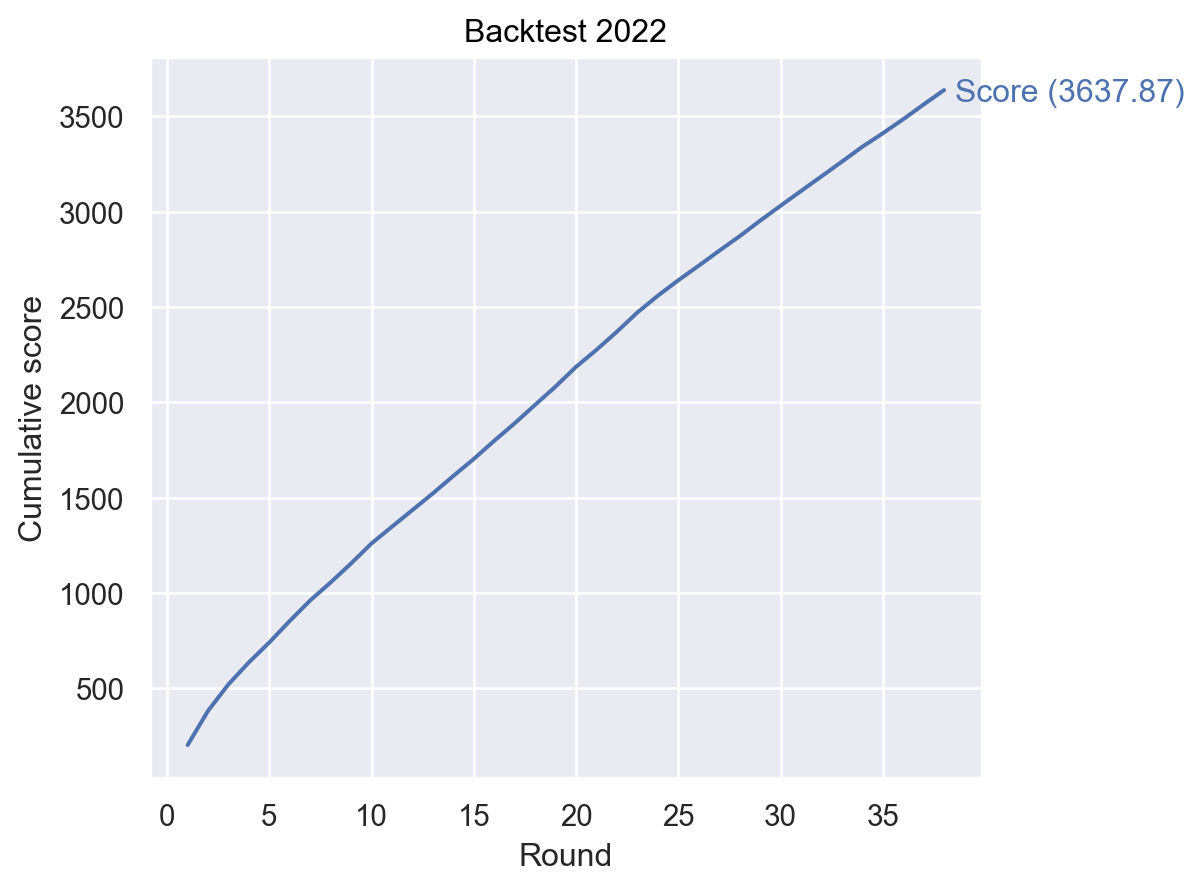

In [15]:
#| label: team-picking-backtest-score
import seaborn.objects as so


def summarize(teams: pl.DataFrame, model: str) -> pl.DataFrame:
    captains = (
        teams.filter(pl.col("position") != 6)
        .filter(
            pl.col("prediction") == pl.col("prediction").over("round").max()
        )
        .with_columns(captain=2.0)
        .select("round", "id", "captain")
    )  # TODO review
    campaign = (
        teams.join(captains, on=["round", "id"], how="left")
        .with_columns(score=pl.col("score") * pl.col("captain").fill_null(1.0))
        .group_by("round")
        .agg(score=pl.col("score").sum())
        .with_columns(score=pl.col("score").cumsum())
    )
    score = campaign.get_column("score").tail(1).round(2).item()
    label = f"{model} ({score})"
    campaign = campaign.with_columns(label=pl.lit(label))
    return campaign


def add_line(
    fig: so.Plot, campaign: pl.DataFrame, linestyle: str = "solid"
) -> so.Plot:
    text = campaign.tail(1)
    fig = fig.add(
        so.Line(linestyle=linestyle),
        data=campaign,
        legend=False,
    ).add(
        so.Text({"clip_on": False}, halign="left", offset=4),
        data=text,
    )
    return fig


season = summarize(teams, "Score")
fig = so.Plot(season, x="round", y="score", color="label", text="label").label(
    title="Backtest 2022", x="Round", y="Cumulative score"
)
fig = add_line(fig, season)
fig

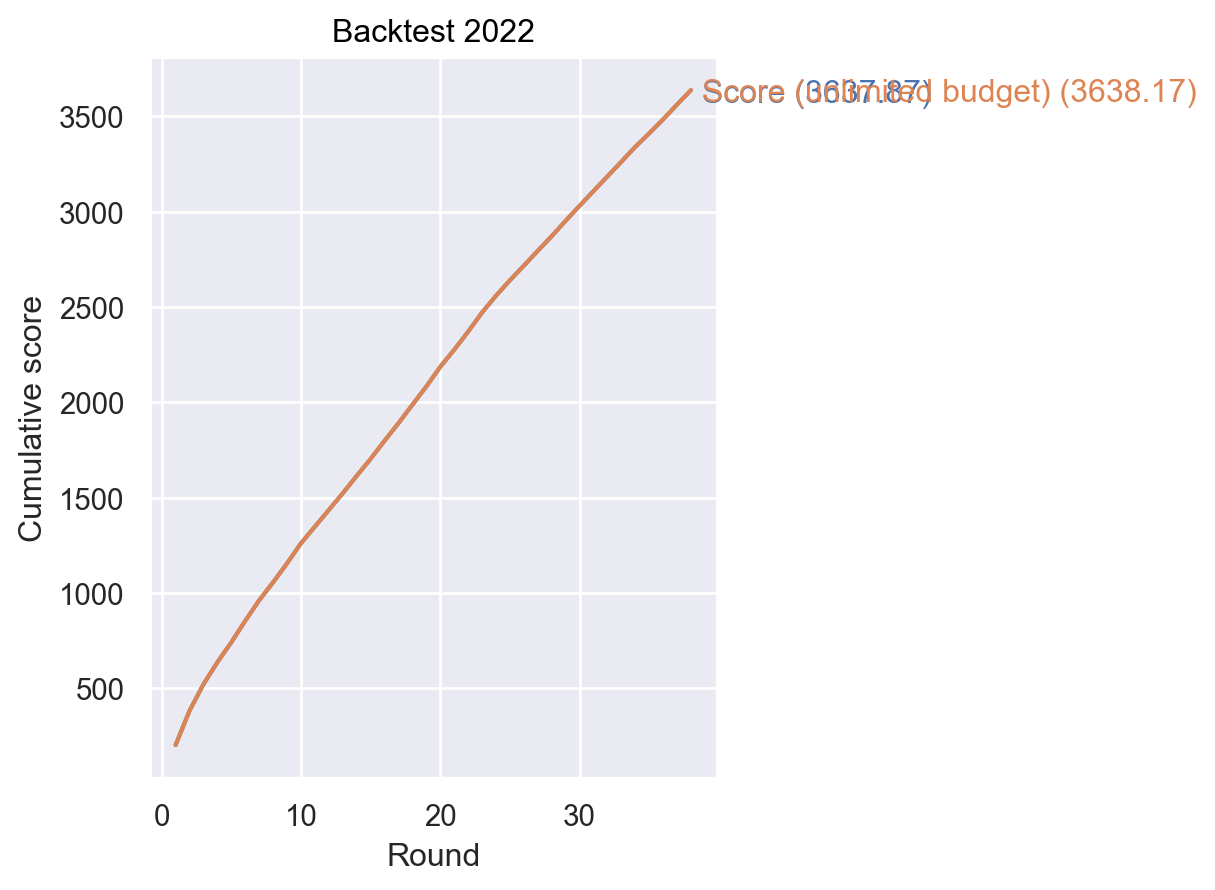

In [16]:
#| label: team-picking-backtest-score-minimum
def add_backtest(fig: so.Plot, teams: pl.DataFrame, model: str) -> so.Plot:
    campaign = summarize(teams, model)
    fig = add_line(fig, campaign)
    return fig


teams = backtest(players, predict_score, initial_budget=1000.0)
add_backtest(fig, teams, "Score (unlimited budget)").facet("label")

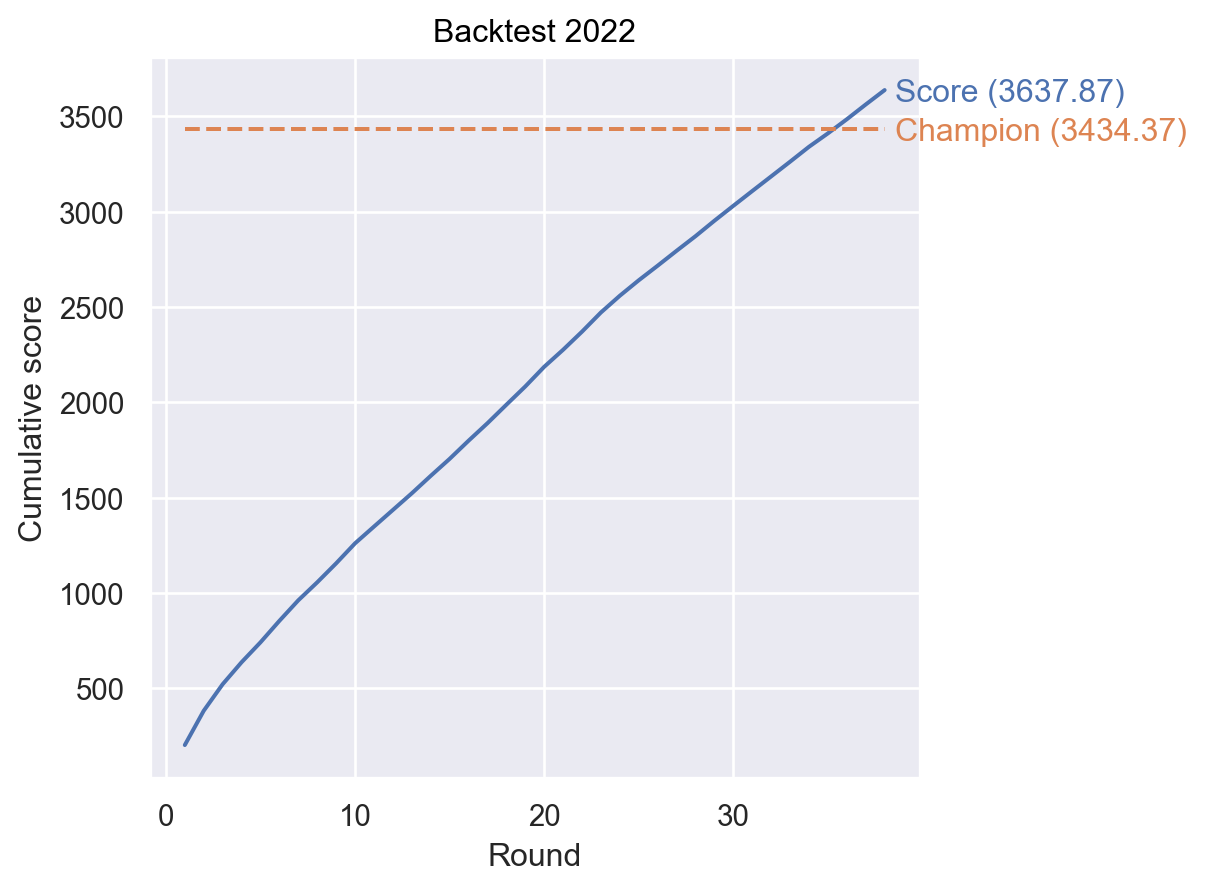

In [17]:
#| label: team-picking-backtest-champion
champion = players.unique("round").with_columns(
    score=pl.lit(3434.37), label=pl.lit("Champion (3434.37)")
)
fig = add_line(fig, champion, linestyle="dashed")
fig

In [18]:
#| label: score-prediction-random-effect
import arviz as az
import bambi as bmb
import logging

logger = logging.getLogger("pymc")
logger.propagate = False


def predict(inference: az.InferenceData, data: pl.DataFrame):
    predictions = model.predict(
        inference, kind="mean", data=data, sample_new_groups=True, inplace=False
    )
    summary = az.summary(predictions, var_names=["score_mean"])
    mean_predictions = summary["mean"].values
    return mean_predictions


data = players.filter(pl.col("round") < round + 1).to_pandas()
model = bmb.Model("score ~ (1 | id)", data=data, categorical="id")
inference = model.fit(progressbar=False)
market = players.filter(pl.col("round") == round).to_pandas()
predictions = predict(inference, market)
print(predictions)


"""
### Fixed effects

#### Team
#### Opposing team
#### Home
"""

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/assuncaolfi/Projects/blog/posts/fantasy-football/.venv/lib/python3.11/site-packages/formulae/terms/variable.py:87: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_string_dtype(x) or is_categorical_dtype(x):


Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [score_sigma, Intercept, 1|id_sigma, 1|id_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


[2.243 4.364 3.748 2.305 4.825 0.749 1.297 5.135 3.946 4.328 5.272 5.561
 4.567 4.511 2.527 3.035 4.723 1.594 2.21  5.718 2.649 2.537 2.358 3.719
 3.496 6.105 3.715 3.804 1.873 2.294 2.412 4.829 2.466 4.759 4.087 2.637
 3.232 2.986 3.56  1.459 2.311 4.365 2.213 4.74  7.132 4.444 4.076 7.104
 3.809 2.982 2.568 3.558 2.843 4.499 2.114 1.807 5.014 2.449 3.027 4.814
 0.882 3.479 2.654 0.871 5.054 0.856 1.709 1.278 4.52  0.926 6.065 2.857
 1.313 3.782 3.623 3.388 0.827 2.74  2.848 4.021 5.979 1.351 3.045 0.981
 4.466 6.722 2.657 2.945 2.749 3.611 2.441 4.571 3.166 0.978 5.138 3.717
 1.78  1.433 3.031 1.861 1.469 1.485 2.336 4.049 3.771 2.92  3.421 3.977
 2.167 4.06  1.167 3.013 1.932 4.879 6.557 1.811 4.061 4.668 3.446 2.073
 2.445 1.386 5.08  2.576 6.23  2.216 1.371 3.325 0.316 1.67  4.344 1.783
 5.306 2.117 0.748 5.553 2.198 3.537 2.246 4.533 2.038 1.985 3.604 3.981
 1.712 2.378 5.147 3.198 1.937 2.327 3.419 3.687 1.789 0.918 1.496 2.655
 2.612 5.053 2.585 4.8   1.904 1.707 1.404 4.041 4.

'\n### Fixed effects\n\n#### Team\n#### Opposing team\n#### Home\n'